In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import random
from tqdm import tqdm
import cv2



In [8]:

# Configuración
INPUT_CSV = "C:/Users/34629/TFG/single_label_dataset_without_H.csv"
OUTPUT_DIR = 'C:/Users/34629//TFG/augmented_images'
TARGET_COUNT = 2000  # Número objetivo de imágenes por clase
CLASSES = ['G', 'C', 'A', 'M']  # Clases minoritarias

# Crear directorio de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)



In [9]:
df_leido = pd.read_csv(INPUT_CSV, sep=';')

# Mostrar el número total de filas
print(f"Número total de filas: {len(df_leido)}")

Número total de filas: 6699


In [10]:

def load_and_preprocess_image(image_path):
    """Carga y preprocesa la imagen"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None



In [11]:

def apply_augmentation(image):
    """Aplica una combinación aleatoria de transformaciones"""
    transformations = []

    # 1. Rotación aleatoria
    angle = random.choice([90, 180, 270])
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    transformations.append(f"rot_{angle}")

    # 2. Flip horizontal o vertical
    if random.random() > 0.5:
        image = cv2.flip(image, 1)  # 1 para flip horizontal
        transformations.append("flip_h")
    if random.random() > 0.5:
        image = cv2.flip(image, 0)  # 0 para flip vertical
        transformations.append("flip_v")

    # 3. Brillo y contraste
    alpha = random.uniform(0.8, 1.2)  # Contraste
    beta = random.uniform(-30, 30)    # Brillo
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    transformations.append(f"bright_{beta:.1f}_cont_{alpha:.1f}")

    # 4. Traslación aleatoria
    tx = random.randint(-50, 50)
    ty = random.randint(-50, 50)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (cols, rows))
    transformations.append(f"trans_{tx}_{ty}")

    # 5. Zoom aleatorio
    if random.random() > 0.5:
        scale = random.uniform(0.8, 1.2)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 0, scale)
        image = cv2.warpAffine(image, M, (cols, rows))
        transformations.append(f"zoom_{scale:.1f}")

    # 6. Ruido gaussiano
    if random.random() > 0.5:
        noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
        image = cv2.add(image, noise)
        transformations.append("noise")

    return image, "_".join(transformations)



In [12]:

# Leer el dataset
df = pd.read_csv(INPUT_CSV, sep=';')

# Lista para almacenar las nuevas filas
new_rows = []

# Procesar cada clase minoritaria
for class_name in CLASSES:
    # Obtener imágenes de la clase actual
    class_images = df[df[class_name] == 1]
    current_count = len(class_images)
    needed_count = TARGET_COUNT - current_count

    print(f"\nProcesando clase {class_name}: generando {needed_count} nuevas imágenes")

    # Generar nuevas imágenes hasta alcanzar el objetivo
    for i in tqdm(range(needed_count)):
        # Seleccionar una imagen aleatoria de la clase
        original_row = class_images.sample(1).iloc[0]

        # Cargar y aumentar la imagen
        image = load_and_preprocess_image(original_row['Image_Path'])
        if image is None:
            continue

        # Aplicar augmentación
        augmented_image, transform_desc = apply_augmentation(image)

        # Generar nuevo nombre de archivo y guardarlo
        base_name = os.path.basename(original_row['Image_Path'])
        new_filename = f"{class_name}_aug_{i}_{transform_desc}_{base_name}"
        new_path = os.path.join(OUTPUT_DIR, new_filename).replace('\\', '/')

        # Guardar la imagen aumentada
        cv2.imwrite(new_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

        # Crear nueva fila para el CSV
        new_row = original_row.copy()
        new_row['Image_Path'] = new_path
        new_rows.append(new_row)



# Crear DataFrame con las nuevas imágenes
aug_df = pd.DataFrame(new_rows)


Procesando clase G: generando 1740 nuevas imágenes


100%|██████████| 1740/1740 [22:12<00:00,  1.31it/s] 



Procesando clase C: generando 1708 nuevas imágenes


100%|██████████| 1708/1708 [08:25<00:00,  3.38it/s]



Procesando clase A: generando 1758 nuevas imágenes


100%|██████████| 1758/1758 [07:37<00:00,  3.84it/s]



Procesando clase M: generando 1762 nuevas imágenes


100%|██████████| 1762/1762 [07:34<00:00,  3.88it/s]


In [13]:

# Concatenar con el dataset original y guardar
df_final = pd.concat([df, aug_df], ignore_index=True)
df_final.to_csv('C:/Users/34629/TFG/augmented_dataset.csv', sep=';', index=False)

In [14]:

# Mostrar estadísticas finales
print("\nEstadísticas finales:")
for class_name in CLASSES:
    original_count = len(df[df[class_name] == 1])
    final_count = len(df_final[df_final[class_name] == 1])
    print(f"Clase {class_name}:")
    print(f"  - Original: {original_count} imágenes")
    print(f"  - Final: {final_count} imágenes")
    print(f"  - Generadas: {final_count - original_count} imágenes")


Estadísticas finales:
Clase G:
  - Original: 260 imágenes
  - Final: 2000 imágenes
  - Generadas: 1740 imágenes
Clase C:
  - Original: 292 imágenes
  - Final: 2000 imágenes
  - Generadas: 1708 imágenes
Clase A:
  - Original: 242 imágenes
  - Final: 2000 imágenes
  - Generadas: 1758 imágenes
Clase M:
  - Original: 238 imágenes
  - Final: 2000 imágenes
  - Generadas: 1762 imágenes


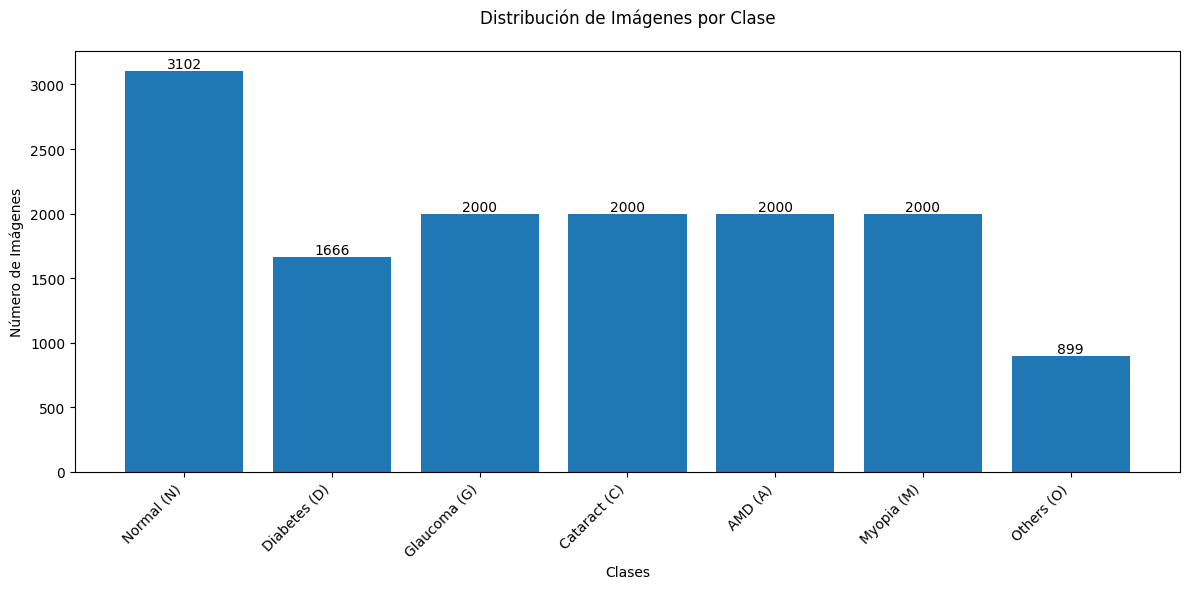


Número exacto de imágenes por clase:
Normal (N): 3102
Diabetes (D): 1666
Glaucoma (G): 2000
Cataract (C): 2000
AMD (A): 2000
Myopia (M): 2000
Others (O): 899


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer el dataset
df = pd.read_csv('C:/Users/34629/TFG/augmented_dataset.csv', sep=';')

# Contar el número de imágenes por clase
class_counts = {
    'Normal (N)': df['N'].sum(),
    'Diabetes (D)': df['D'].sum(),
    'Glaucoma (G)': df['G'].sum(),
    'Cataract (C)': df['C'].sum(),
    'AMD (A)': df['A'].sum(),
    'Myopia (M)': df['M'].sum(),
    'Others (O)': df['O'].sum()
}

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribución de Imágenes por Clase', pad=20)
plt.xlabel('Clases')
plt.ylabel('Número de Imágenes')

# Rotar las etiquetas para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Añadir los valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Ajustar el layout para que no se corten las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Imprimir los valores exactos
print("\nNúmero exacto de imágenes por clase:")
for clase, cantidad in class_counts.items():
    print(f"{clase}: {int(cantidad)}")